In [1]:
import pandas
import matplotlib.pyplot as plt
import pickle
import wntr
from testWN import testWN as twm
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration

In [2]:
%matplotlib notebook

# Get Network Information

In [3]:
inp_file = '../Networks/BWCNdata/c-town_true_network.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)

pump_df = pd.DataFrame(np.ones(len(link_names[0])).reshape(1,-1), columns=link_names[0])
valves_df = pd.DataFrame(np.ones(len(link_names[2])).reshape(1,-1), columns=link_names[2])

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Networks/BWCNdata/c-town_true_network.inp"; added with type None, units conversion left to user



# Get Connectivity Matrix

Infos about connectivity matrix [here](https://transportgeography.org/?page_id=6969).

In [4]:
A = np.zeros((n_junctions,n_junctions))
links = ctown.wn.links.todict()
for key in links.keys():
    i = np.where([np.array(node_names[2]) == links[key]['start_node_name']])[1]
    j = np.where([np.array(node_names[2]) == links[key]['end_node_name']])[1]
    
    A[i,j] = 1
    A[j,1] = 1

<IPython.core.display.Javascript object>


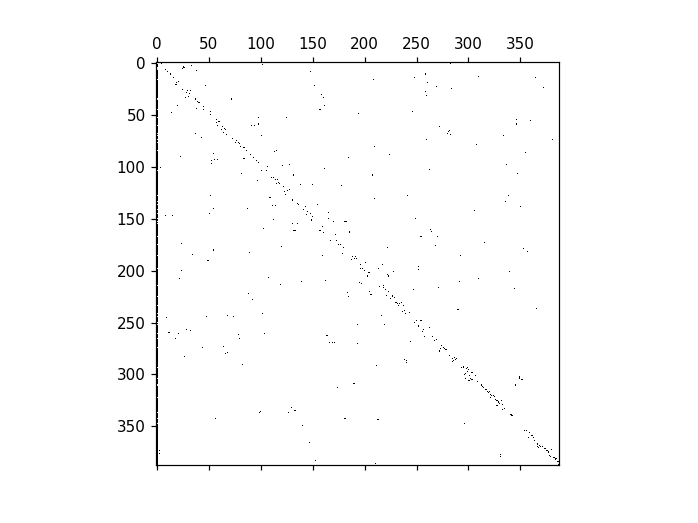

In [5]:
plt.figure()
plt.spy(A)

# Get Coordinates of nodes:

In [31]:
nodes = ctown.wn.nodes.todict()

In [32]:
coords = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords_rep = np.repeat(coords,240, axis=1)
coords = pd.DataFrame(coords_rep, index=node_names_all)
junction_coords = coords.loc[node_names[2]]

# Clustering

In [50]:
with open('results.pkl', 'rb') as f:
    results=pickle.load(f)

In [51]:
press_junctions =results.node['pressure'][node_names[2]]
qual_junctions = results.node['quality'][node_names[2]]

Normalize Data:

In [52]:
press_junctions /= press_junctions.max()
qual_junctions /=  qual_junctions.max()
junction_coords /= junction_coords.max()

Weighting:

In [53]:
press_junctions *= 1
qual_junctions *=  1
junction_coords *= 0

Create Training Data

In [54]:
X = np.concatenate((press_junctions.to_numpy(),
               qual_junctions.to_numpy(),
               junction_coords.to_numpy().T))

In [55]:
clustering = FeatureAgglomeration(n_clusters=20, connectivity=A, linkage='ward').fit(X)

In [56]:
cluster_labels = pd.DataFrame(clustering.labels_, index=node_names[2])

<IPython.core.display.Javascript object>


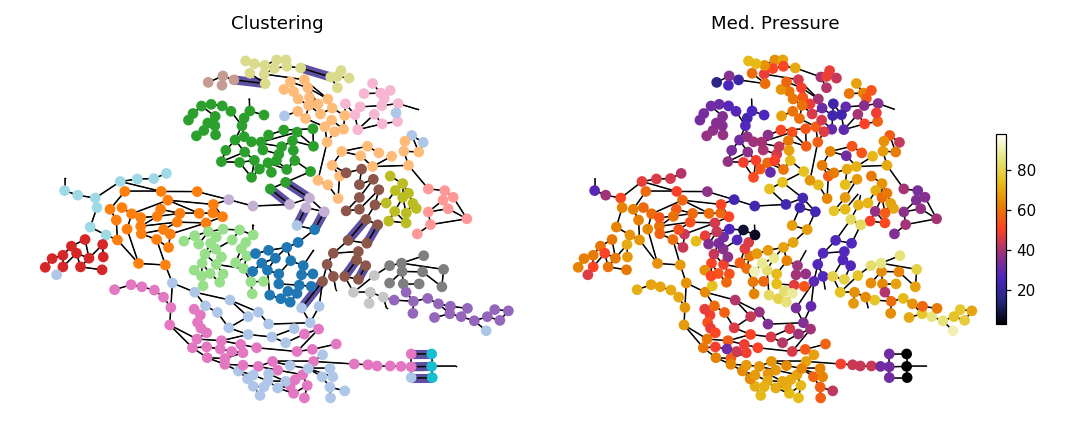

In [57]:
fig_1, ax_1 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
press = results.node['pressure']
press_med = press.mean()

wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Pumps', ax=ax_1[0])
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Valves', ax=ax_1[0])

wntr.graphics.plot_network(ctown.wn, node_attribute=cluster_labels[0],node_size=50, node_labels=False, node_cmap='tab20',add_colorbar=False, title='Clustering', ax=ax_1[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]],node_size=50, node_cmap='CMRmap', title='Med. Pressure', ax=ax_1[1])  # junctions

fig_1.tight_layout()